In [1]:
import pandas  as pd
import geopandas as gpd
import sys
import numpy as np
from joblib import Parallel, delayed
import itertools
import matplotlib.pyplot as plt
import time
import os
import gc
import warnings
warnings.filterwarnings('ignore')

## Carga de datos

In [2]:
zones = gpd.read_file('./taxi_zones.shp').to_crs({'init' :'epsg:4326'})
zones['zone'] = zones.zone.astype('category')
zones['borough'] = zones.borough.astype('category')
zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


In [3]:
files = ['yellow_tripdata_2020-01.csv',
         'yellow_tripdata_2020-02.csv',
         'yellow_tripdata_2020-03.csv',
         'yellow_tripdata_2020-04.csv',
         'yellow_tripdata_2020-05.csv',
         'yellow_tripdata_2020-06.csv',
         'yellow_tripdata_2020-07.csv',
         'yellow_tripdata_2020-08.csv', 
         'yellow_tripdata_2020-09.csv',
         'yellow_tripdata_2020-10.csv',
         'yellow_tripdata_2020-11.csv',
         'yellow_tripdata_2020-12.csv'
         
        ] 

In [4]:
taxis_yellow = pd.DataFrame()
for i in files[:8]:
      taxis_yellow= pd.concat([taxis_yellow, pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/'+i )])
    

In [5]:
taxis_yellow.reset_index(inplace=True, drop=True)

In [6]:
pull_lis= [taxis_yellow[taxis_yellow['PULocationID'] == i] for i in  zones['LocationID'].unique()]

In [7]:
def no_voy_para_alla(taxis_df,  df_poly):
    group_by_count = taxis_df[['DOLocationID','total_amount' ]].groupby([ 'DOLocationID']).count()
    group_by_amount = taxis_df[['DOLocationID','total_amount' , 'trip_distance']].groupby(['DOLocationID']).mean()
    group_by_count.reset_index(inplace= True)
    group_by_amount.reset_index(inplace= True)
    out_df = group_by_count.merge(group_by_amount, how= 'left', on = 'DOLocationID')
    #print(id_loc_pull)
    
    if out_df.empty:
        
        return pd.DataFrame()
    #print(out_df.iloc[out_df['total_amount_x'].idxmax()]['DOLocationID'])
    out_df['conveniencia'] = out_df.apply(lambda l : (l.total_amount_x*l.total_amount_y)/l.trip_distance, axis= 1)
    out_df= out_df.merge(right =df_poly[['LocationID' , 'geometry']], how = 'right', left_on='DOLocationID', right_on= 'LocationID' )
    return out_df

In [8]:
no_voy_para_alla(pull_lis[0],   zones)

,DOLocationID,total_amount_x,total_amount_y,trip_distance,conveniencia,LocationID,geometry
0,1.0,1528.0,93.154869,0.787834,180673.443417,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,NaN,NaN,NaN,NaN,NaN,2,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,NaN,NaN,NaN,NaN,NaN,3,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,NaN,NaN,NaN,NaN,NaN,4,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,NaN,NaN,NaN,NaN,NaN,5,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."
...,...,...,...,...,...,...,...
258,NaN,NaN,NaN,NaN,NaN,259,"POLYGON ((-73.85107 40.91037, -73.85207 40.909..."
259,NaN,NaN,NaN,NaN,NaN,260,"POLYGON ((-73.90175 40.76078, -73.90147 40.759..."
260,NaN,NaN,NaN,NaN,NaN,261,"POLYGON ((-74.01333 40.70503, -74.01327 40.704..."
261,NaN,NaN,NaN,NaN,NaN,262,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ..."


In [9]:
%%time
df_no_voy = Parallel(n_jobs=8,backend='multiprocessing')(delayed(
    no_voy_para_alla)(i, zones ) for i in pull_lis)

CPU times: user 15.7 s, sys: 2.62 s, total: 18.3 s
Wall time: 17.9 s


In [10]:
%%time
li_lo = []
for i in pull_lis:
    li_lo.append(no_voy_para_alla( i, zones))

CPU times: user 2.43 s, sys: 629 µs, total: 2.43 s
Wall time: 2.44 s


In [11]:
df_no_voy[1]

,DOLocationID,total_amount_x,total_amount_y,trip_distance,conveniencia,LocationID,geometry
0,NaN,NaN,NaN,NaN,NaN,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2.0,1.0,12.35,1.5,8.233333,2,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,NaN,NaN,NaN,NaN,NaN,3,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,NaN,NaN,NaN,NaN,NaN,4,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,NaN,NaN,NaN,NaN,NaN,5,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."
...,...,...,...,...,...,...,...
258,NaN,NaN,NaN,NaN,NaN,259,"POLYGON ((-73.85107 40.91037, -73.85207 40.909..."
259,NaN,NaN,NaN,NaN,NaN,260,"POLYGON ((-73.90175 40.76078, -73.90147 40.759..."
260,NaN,NaN,NaN,NaN,NaN,261,"POLYGON ((-74.01333 40.70503, -74.01327 40.704..."
261,NaN,NaN,NaN,NaN,NaN,262,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ..."


<AxesSubplot:>

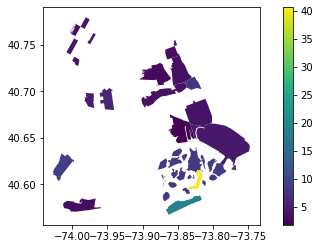

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(8,4))
geo_pan= gpd.GeoDataFrame(df_no_voy[1])
geo_pan.plot(column='conveniencia' , ax= axs, legend=True)

In [13]:
def no_voy_para_alla_mes(url ,  df_poly):
    """Lee un dataframe y regresa un dataframe con la cuentas de nuestro indice
    """
    lis_lo_mes= []
    taxis_df= pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/'+url )
    for i in df_poly.LocationID.unique():
        taxis_df_te = taxis_df[taxis_df['PULocationID'] == i]
        group_by_count = taxis_df_te[['PULocationID', 'DOLocationID','total_amount' ]].groupby(['PULocationID', 'DOLocationID']).count()
        group_by_amount = taxis_df_te[['PULocationID','DOLocationID','total_amount' , 'trip_distance']].groupby(['PULocationID', 'DOLocationID']).mean()
        group_by_count.reset_index(inplace= True)
        group_by_amount.reset_index(inplace= True)
        out_df = group_by_count.merge(group_by_amount, how= 'left', on = 'DOLocationID')
        if out_df.empty:
            lis_lo_mes.append({'url':url,'Id_pul':i, 'geo_df': pd.DataFrame()})
        else:
            out_df['conveniencia'] = out_df.apply(lambda l : (l.total_amount_x*l.total_amount_y)/l.trip_distance, axis= 1)
            out_df= out_df.merge(right =df_poly[['LocationID' , 'geometry']], how = 'right', left_on='DOLocationID', right_on= 'LocationID' )
            lis_lo_mes.append({'url':url,'Id_pul':i, 'geo_df': out_df})

    return lis_lo_mes

In [14]:
%%time
mes_1= no_voy_para_alla_mes('yellow_tripdata_2020-01.csv', zones)

CPU times: user 15.7 s, sys: 2.29 s, total: 18 s
Wall time: 1min 52s


In [15]:
mes_1[2]

{'url': 'yellow_tripdata_2020-01.csv',
 'Id_pul': 3,
 'geo_df':      PULocationID_x  DOLocationID  total_amount_x  PULocationID_y  \
 0               NaN           NaN             NaN             NaN   
 1               NaN           NaN             NaN             NaN   
 2               3.0           3.0             8.0             3.0   
 3               3.0           4.0             1.0             3.0   
 4               NaN           NaN             NaN             NaN   
 ..              ...           ...             ...             ...   
 258             NaN           NaN             NaN             NaN   
 259             3.0         260.0             2.0             3.0   
 260             NaN           NaN             NaN             NaN   
 261             NaN           NaN             NaN             NaN   
 262             3.0         263.0             1.0             3.0   
 
      total_amount_y  trip_distance  conveniencia  LocationID  \
 0               NaN          

<AxesSubplot:>

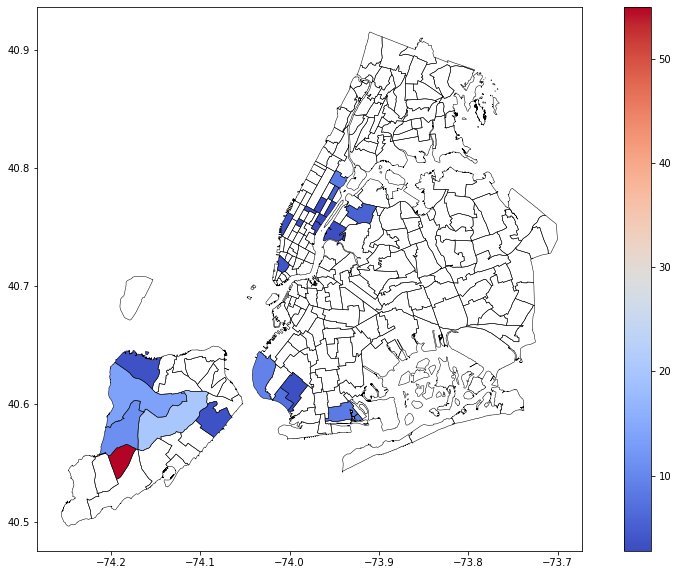

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(15,10))
gpd_plot=gpd.GeoDataFrame(mes_1[4]['geo_df'])
gpd_plot.geometry.boundary.plot(color=None,edgecolor='k',linewidth = .5,ax=axs) 
gpd_plot.plot(column='conveniencia' , ax= axs, cmap='coolwarm', legend=True)


In [17]:
%%time
year_2020= Parallel(n_jobs=4,backend='multiprocessing')(delayed(
    no_voy_para_alla_mes)(i, zones ) for i in files )

CPU times: user 22.8 s, sys: 4.26 s, total: 27 s
Wall time: 3min 24s


<AxesSubplot:>

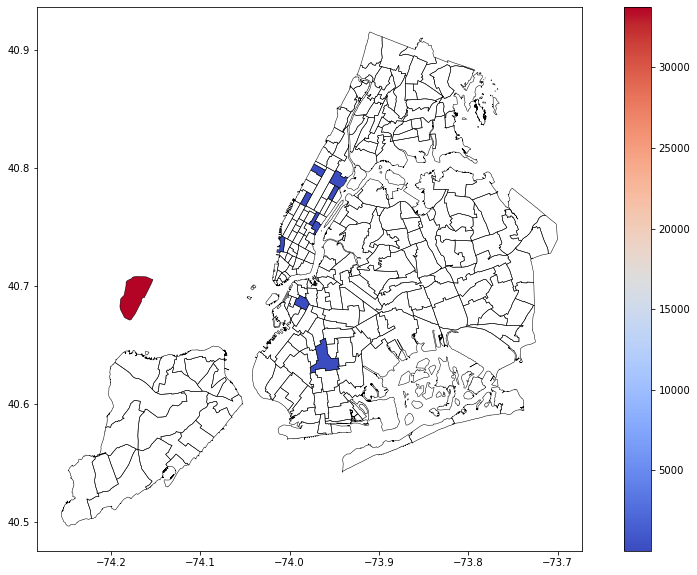

In [18]:

fig, axs = plt.subplots(1, 1, figsize=(15,10))
gpd_plot=gpd.GeoDataFrame(year_2020[2][0]['geo_df'])
gpd_plot.geometry.boundary.plot(color=None,edgecolor='k',linewidth = .5,ax=axs) 
gpd_plot.plot(column='conveniencia' , ax= axs, cmap='coolwarm', legend=True)


In [19]:
def image_prod(year_list, id_pull,path):
    print('to save: ' , path+str(id_pull))
    create_dir =path+'/LocaldI_'+str(id_pull) 
    os.mkdir(create_dir)
    geo_df_all=[]
    for i in year_list:
        #print(i[id_pull]['Id_pul'])
        pul= i[id_pull]['Id_pul']
        str_i=i[id_pull]['url']
        str_i_s=str_i[str_i.rfind('.')-2:str_i.rfind('.')]
        ### checar si es vacio
        
        if not i[id_pull]['geo_df'].empty:
                        
            geo_df_id= gpd.GeoDataFrame(i[id_pull]['geo_df'])
            fig, axs = plt.subplots(1, 1, figsize=(15,10))
            axs.axis('off')
            geo_df_id.geometry.boundary.plot(color=None,edgecolor='k',linewidth = .5,ax=axs) 
            geo_df_id.plot(column='conveniencia' , ax= axs, cmap='coolwarm', legend=True)
            file_path= create_dir+'/test_pul_'+str(pul)+'_month_'+str_i_s+'.png'
            #print('to_save: ',file_path)
            fig.savefig(file_path, dpi=300)
            

In [20]:
#image_prod(year_2020, 0, './Images')

## Generar muchos mapas

In [29]:
def image_prod_2(year_list_single, path):
    #print('to save: ' , path+str(id_pull))
    
    for i in year_list_single:
        #print(i[id_pull]['Id_pul'])
        
        pul= i['Id_pul']
        str_i=i['url']
        str_i_s=str_i[str_i.rfind('.')-2:str_i.rfind('.')]
        create_dir =path+'/LocaldI_'+str(pul) 
        ### checar si es vacio
        if os.path.exists(create_dir)==False:
            os.mkdir(create_dir)
            
        if not i['geo_df'].empty:
                        
            geo_df_id= gpd.GeoDataFrame(i['geo_df'])
            fig, axs = plt.subplots(1, 1, figsize=(15,10))
            axs.axis('off')
            geo_df_id.geometry.boundary.plot(color=None,edgecolor='k',linewidth = .5,ax=axs) 
            geo_df_id.plot(column='conveniencia' , ax= axs, cmap='coolwarm', legend=True)
            file_path= create_dir+'/test_pul_'+str(pul)+'_month_'+str_i_s+'.png'
            #print('to_save: ',file_path)
            fig.savefig(file_path, dpi=300)
            del fig
            del axs
            del geo_df_id
            del file_path
            
        del pul 
        del str_i
        del create_dir    
        gc.collect()
    plt.ioff()
    plt.close()
    gc.collect()
    return 

## Borrar 
Eliminemos las cosas que no necesitamos

In [26]:
del taxis_yellow
del li_lo
del mes_1
del df_no_voy
del pull_lis
gc.collect()

NameError: name 'taxis_yellow' is not defined

In [31]:
%%time
%%capture out
image_prod_2(year_2020[0], './Images')

CPU times: user 5min 21s, sys: 2.82 s, total: 5min 24s
Wall time: 5min 24s


In [32]:
gc.collect()

1537193

In [39]:
import joblib
joblib.__version__

'1.0.1'

In [ ]:
%%time
%%capture out
Parallel(n_jobs=2,backend='loky')(delayed(
    image_prod_2)(i, './Images' ) for i in year_2020[:6] )

In [ ]:
gc.collect()

In [ ]:
%%time
Parallel(n_jobs=2,backend='loky')(delayed(
    image_prod_2)(i, './Images' ) for i in year_2020[6:] )